# LuxonisDatasetFormat - testing embeddings methods

In [1]:
import os
import uuid

import onnxruntime
import torch
import torch.onnx
import torchvision
from matplotlib import pyplot as plt
from utils.data_utils import load_mnist_data
from utils.torch_utils import (
    export_model_onnx,
    extract_embeddings_onnx,
    extract_embeddings_torch,
    load_embeddings,
    load_model_resnet50,
    save_embeddings,
)

from luxonis_ml.data import (
    LuxonisDataset,
    LuxonisLoader,
)
from luxonis_ml.embeddings.utils.ldf import generate_embeddings
from luxonis_ml.embeddings.utils.model import (
    extend_output_onnx,
    load_model_onnx,
    save_model_onnx,
)
from luxonis_ml.embeddings.utils.qdrant import QdrantAPI, QdrantManager

## Pytorch examples

This section shows how to extract embeddings using a ResNet50 model from PyTorch and it provides a simple way to load the data into a PyTorch DataLoader.

In [2]:
# Load the data
data_loader = load_mnist_data(
    save_path="./data/mnist", num_samples=640, batch_size=64
)

In [3]:
# Load the model
model = load_model_resnet50(discard_last_layer=True)

In [4]:
# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_torch(model, data_loader)

In [5]:
save_embeddings(embeddings, labels, "./data/")

## ONNX models and Qdrant

This section shows how to convert the PyTorch model to ONNX and how to use the ONNX model to extract embeddings. It also shows how to use the Qdrant library to index the embeddings and to perform a simple search.

In [6]:
# Load the data
data_loader = load_mnist_data(
    save_path="./data/mnist", num_samples=640, batch_size=64
)

Here are the steps to convert the PyTorch model to ONNX and then expose the specified layer as an embedding layer (here specifically the layer named '/Flatten_output_0'). 

To see the graph and layer names, you can use the Netron tool (https://netron.app/).

You can set the overwrite parameter of extend_output_onnx method to True to use the second to last layer as the embedding layer and rename it.

In [7]:
# Load the model
model = load_model_resnet50(discard_last_layer=False)

# Export the model to ONNX
export_model_onnx(model, model_path_out="./data/resnet50.onnx")

# Load the ONNX model
onnx_model = load_model_onnx(model_path="./data/resnet50.onnx")

# Extend the ONNX model with an intermediate output layer
onnx_model = extend_output_onnx(
    onnx_model, intermediate_tensor_name="/Flatten_output_0"
)

# Save the ONNX model
save_model_onnx(onnx_model, model_path_out="./data/resnet50-1.onnx")

In [8]:
# Create an ONNX Runtime session
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession(
    "./data/resnet50-1.onnx", providers=provider
)

# Extract embeddings from the dataset
embeddings, labels = extract_embeddings_onnx(
    ort_session, data_loader, "/Flatten_output_0"
)

# Save the embeddings and labels to a file
save_embeddings(embeddings, labels, "./data/")

In [9]:
embeddings, labels = load_embeddings("./data/")
embeddings = embeddings.tolist()
labels = labels.tolist()

In [10]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container").start_docker_qdrant()

Container is already running.


In [11]:
# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333)

In [13]:
# Create a collection
vector_size = len(embeddings[0])
qdrant_api.create_collection(
    collection_name="Mnist", properties=["label"], vector_size=vector_size
)

Collection already exists


In [14]:
# Insert the embeddings into the collection
ids = [str(uuid.uuid5(uuid.NAMESPACE_DNS, str(e))) for e in embeddings]
label_list_dict = [{"label": label_i} for label_i in labels]
qdrant_api.insert_embeddings(ids, embeddings, label_list_dict, batch_size=50)

In [15]:
# Search for the nearest neighbors
ids, scores = qdrant_api.search_similar_embeddings(embeddings[0], top_k=5)
payloads = qdrant_api.retrieve_payloads_by_ids(ids)

for id, score, payload in zip(ids, scores, payloads):
    print(f"ID: {id}, Score: {score}, Label: {payload['label']}")

ID: 0b86b9d1-d362-50af-9e49-c7c7c9202136, Score: 1.0, Label: 9
ID: 2af41a63-7d54-515f-a13d-e8917353bf82, Score: 1.0, Label: 9
ID: f163d72e-2e79-5ef0-98c9-a7b21be4e147, Score: 0.98906696, Label: 9
ID: 51ce317e-0e8d-5d95-af18-5988c76135ae, Score: 0.9890652, Label: 9
ID: fb82b61a-7ce7-5756-bc18-fdc74a3de2e3, Score: 0.98885965, Label: 9


## LuxonisDatasetFormat, ONNX and Qdrant

This section shows how to use the LuxonisDatasetFormat to load the data and how to use the ONNX model to extract embeddings. It also shows how to use the Qdrant library to index the embeddings and to perform a simple search.

In [16]:
NUM_SAMPLES = 6400  # -1 # minus one is equivalent to all samples
BATCH_SIZE = 64

In [17]:
# Load the MNIST data
data_loader = load_mnist_data(
    save_path="./data/mnist", num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE
)
NUM_SAMPLES = len(data_loader.dataset)
print(f"Number of samples: {NUM_SAMPLES}")

Number of samples: 6400


In [18]:
# Create a tmp directory to store the images
mnist_image_dir = "./data/mnist_images"
if not os.path.exists(mnist_image_dir):
    os.makedirs(mnist_image_dir)

In [19]:
# Convert MNIST data to Luxonis ML format
def mnist_LDF_generator():
    batch_num = 0
    for batch in data_loader:
        images, labels = batch
        for i, (image, label) in enumerate(zip(images, labels)):
            img_ix = batch_num * BATCH_SIZE + i

            # Save image to disk
            # image_path = os.path.join(mnist_image_dir, f"{uuid.uuid4()}.jpg")
            image_path = os.path.join(mnist_image_dir, f"mnist_{img_ix}.jpg")
            torchvision.utils.save_image(image, image_path)

            # Create dictionary structure for Luxonis ML
            yield {
                "file": image_path,
                "class": str(label.item()),
                "type": "classification",
                "value": True,
            }
        batch_num += 1

In [20]:
# 2. Load the MNIST Data into LDF
dataset_name = "Mnist_LDF"

# Create a new dataset in LDF
dataset = LuxonisDataset(dataset_name)

In [21]:
# Add the MNIST data to the dataset
dataset.set_classes(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
dataset.add(mnist_LDF_generator)
dataset.make_splits()

100%|██████████| 6400/6400 [00:00<00:00, 21490.79it/s]


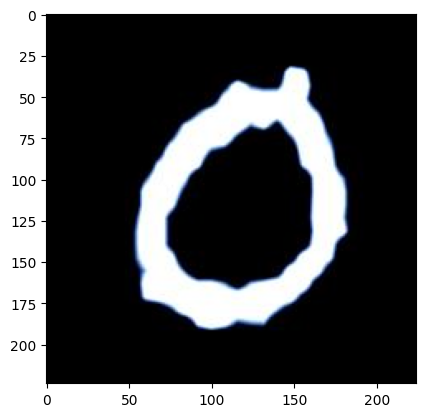

In [22]:
loader = LuxonisLoader(dataset)
for img, _ in loader:
    plt.imshow(img)
    plt.show()
    break

In [23]:
# Initialize the ONNX Runtime session for the model
provider = (
    ["CUDAExecutionProvider"]
    if torch.cuda.is_available()
    and "CUDAExecutionProvider" in onnxruntime.get_available_providers()
    else None
)
ort_session = onnxruntime.InferenceSession(
    "./data/resnet50-1.onnx", providers=provider
)

In [29]:
# Start Qdrant docker container
QdrantManager("qdrant/qdrant", "qdrant_container").start_docker_qdrant()

# Connect to Qdrant
qdrant_api = QdrantAPI("localhost", 6333)

# Create a collection
qdrant_api.create_collection(
    collection_name="Mnist_LDF",
    properties=["label", "image_path"],
    vector_size=2048,
)

Container is already running.
Created new collection


In [30]:
# Load the LuxonisDataset
emb_dict = generate_embeddings(
    dataset, ort_session, qdrant_api, output_layer_name="/Flatten_output_0"
)

Upserted 6400 of embeddings to VectorDB.
Embeddings generation and insertion completed!


In [31]:
first_emb = None

# get a specific sample from dataset
first_sample = list(emb_dict.keys())[0]
first_emb = emb_dict[first_sample]
sample_id = first_sample

df = dataset._load_df_offline()
sample = df[df["instance_id"] == sample_id]
sample

,file,class,type,value,instance_id,value_type,created_at
0,mnist_0.jpg,0,classification,True,c342a0fe-a996-5bd7-ad26-ba0a4041ce42,bool,2024-02-06 11:39:45.238980


In [32]:
# Search for the nearest neighbors
ids, scores = qdrant_api.search_similar_embeddings(first_emb, top_k=5)
payloads = qdrant_api.retrieve_payloads_by_ids(ids)

for id, score, payload in zip(ids, scores, payloads):
    print(f"ID: {id}, Score: {score}, Label: {payload['label']}")

ID: c342a0fe-a996-5bd7-ad26-ba0a4041ce42, Score: 0.99999994, Label: 0
ID: 537d3f8d-c840-5382-aac3-644a9634a033, Score: 0.96481323, Label: 0
ID: 01fbfcdb-4c17-52df-855e-ca3ddcd22486, Score: 0.9581372, Label: 0
ID: 362278b8-b5c8-5165-a8f3-aa9f38c9d3c9, Score: 0.9561764, Label: 0
ID: f06a24bd-9aee-5849-8a95-b8a93b342145, Score: 0.95613754, Label: 0


## Embeddings Processing

In [ ]:
# look at the Embeddings_Processing_Example.ipynb for the rest of the code

## Remove everything

In [ ]:
# ! rm -rf ./data/

In [ ]:
# # Delete the Luxonis ML dataset
# dataset.delete_dataset()

In [ ]:
# # Delete the Qdrant collection
# qdrant_api.delete_collection()

In [ ]:
# # Stop the Qdrant docker container
# QdrantManager("qdrant/qdrant", "qdrant_container").stop_docker_qdrant()